In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
from scipy.stats import mannwhitneyu 

In [2]:
# Object save and load

def save_object(obj, filename):
    try:
        with open(filename, "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print(f"Error during pickling object (Possibly unsupported): {ex}")
        
def load_object(filename):
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print(f"Error during unpickling object (Possibly unsupported): {ex}")
        
# Import subject data

def load_key_data(df_path,dataset_dir,typ_col='Typ/Atyp'):
    df = pd.read_excel(df_path)[['Subject','Typ/Atyp']]
    type_num = []
    for index, row in df.iterrows():
        calc = (df.loc[index,'Typ/Atyp'] == 'Atypical')*1
        type_num.append(calc)
    df['Typ/Atyp'] = type_num
    return df.values

def append_subject_data(sub,dataset_dir,typ,sessions=None):
    X, y = [], []
    for ses in sessions or ['']:
        if ses:
            file = '{}{}_{}.npy'.format(dataset_dir,sub,ses)
        else:
            file = '{}{}.npy'.format(dataset_dir,sub)
        X.append(np.load(file))
        y.append(typ)
    return X, y

# Cross-Validation and Prediction

def perform_cross_validation(df,dataset_dir,n_splits=10,manualSeed=42):
    
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=manualSeed)
    undersampler = RandomUnderSampler(random_state=manualSeed, sampling_strategy=.9)
    
    y_true, y_pred, pred_probs = [], [], []
    
    for k, (train_ix, test_ix) in enumerate(kfold.split(df[:, 0], df[:, 1].astype(int))):
        
        # Prepare training and test subsets
        train_subs, test_subs = df[train_ix, 0], df[test_ix, 0]
        train_y, test_y = df[train_ix, 1].astype(int), df[test_ix, 1].astype(int)
        
        # Under-sample the training data
        subs_undersampled, y_undersampled = undersampler.fit_resample(train_subs.reshape(-1, 1), train_y)
        
        # Load subject data
        X_train, y_train = [], []
        for sub, typ in zip(subs_undersampled, y_undersampled):
            X_sub, y_sub = append_subject_data(sub[0], dataset_dir, typ, sessions=['ses-1', 'ses-2'])
            X_train.extend(X_sub)
            y_train.extend(y_sub)
        
        X_test, y_test = [], []
        for sub, typ in zip(test_subs,test_y):
            X_sub, y_sub = append_subject_data(sub, dataset_dir, typ, sessions=['ses-1', 'ses-2'])
            X_test.extend(X_sub)
            y_test.extend([y_sub[0]])  #Take single subject label for testing


        # Fit the model
        clf = MLPClassifier(random_state=manualSeed, max_iter=500).fit(X_train, y_train)
        
        # Predict probabilities and average for each subject across sessions
        fold_ses_pred_probs = clf.predict_proba(X_test)[:, 1]
        fold_sub_pred_probs = np.mean(fold_ses_pred_probs.reshape(-1, 2), axis=1)
        
        y_true.extend(y_test)
        pred_probs.extend(fold_sub_pred_probs)
        y_pred.extend((fold_sub_pred_probs > 0.5).astype(int))
        
        # Save the model
        save_object(clf, 'model_iteration_{}'.format(k))

    return y_true, y_pred, pred_probs


def analyze_results(y_true, y_pred, pred_probs):
    acc = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    specificity = recall_score(1-np.array(y_true), 1-np.array(y_pred))
    roc_auc = roc_auc_score(y_true, pred_probs)
    _, p_val = mannwhitneyu(np.array(pred_probs)[np.array(y_true) == 1], np.array(pred_probs)[np.array(y_true) == 0])
            
    print('Test metrics: AUC = {:.2f}, p-val = {:.3f}, Sensitivity = {:.2f}, Specificity = {:.2f}, Acc = {:.2f}'.format(
                        roc_auc,p_val,sensitivity,specificity,acc))
    return roc_auc, p_val
    
# Trained model prediction

def trained_model_preds(df,dataset_dir,n_splits=10):
    pred_probs = np.zeros(len(df))
    X, y_true = [], []
    for sub, typ in df:
        X_sub, y_sub = append_subject_data(sub, dataset_dir, typ)
        X.extend(X_sub)
        y_true.extend(y_sub)
    for k in range(n_splits):
        clf = load_object('model_iteration_{}'.format(k))
        iteration_probs = clf.predict_proba(X)[:,1]
        pred_probs += iteration_probs
    pred_probs = pred_probs/n_splits
    y_pred = (pred_probs>.5)*1
    
    return y_true, y_pred, pred_probs

In [3]:
df_path = 'internal_LI_indexes.xlsx'
dataset_dir = './internal_resnet_output_features/'

df = load_key_data(df_path,dataset_dir,typ_col='Typ/Atyp')
y_true, y_pred, pred_probs = perform_cross_validation(df,dataset_dir)
roc_auc, p_val = analyze_results(y_true, y_pred, pred_probs)

Test metrics: AUC = 0.88, p-val = 0.000, Sensitivity = 0.90, Specificity = 0.70, Acc = 0.72


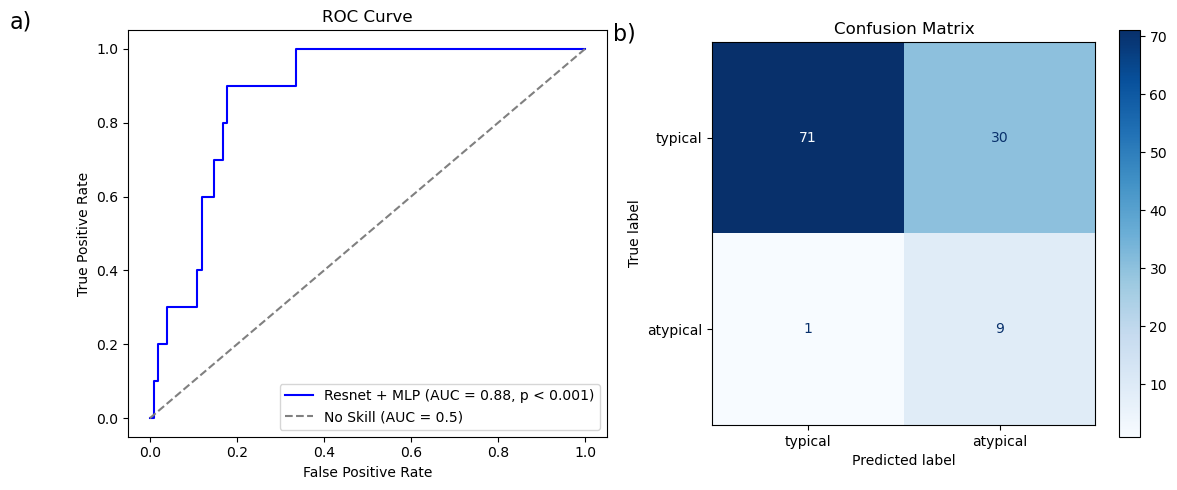

In [4]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
fpr, tpr, thresholds = roc_curve(y_true, pred_probs)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(fpr, tpr, label='Resnet + MLP (AUC = {:.2f}, p < 0.001)'.format(roc_auc), color='Blue')
ax[0].plot([0, 1], [0, 1], linestyle='--', label='No Skill (AUC = 0.5)', color='Grey')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()
ax[0].set_title('ROC Curve')
ax[0].text(-0.2, 1.05, 'a)', transform=ax[0].transAxes, fontsize=16, va='top', ha='right')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['typical', 'atypical'])
disp.plot(cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix')
ax[1].text(-0.2, 1.05, 'b)', transform=ax[1].transAxes, fontsize=16, va='top', ha='right')

plt.tight_layout()
plt.savefig("plot2.pdf")
plt.show()

In [5]:
df_path = 'external_LI_indexes.xlsx'
dataset_dir = './external_resnet_output_features/'

df = load_key_data(df_path,dataset_dir,typ_col='Typ/Atyp')
y_true, y_pred, pred_probs = trained_model_preds(df,dataset_dir)
roc_auc, p_val = analyze_results(y_true, y_pred, pred_probs)

Test metrics: AUC = 0.85, p-val = 0.011, Sensitivity = 0.86, Specificity = 0.77, Acc = 0.80


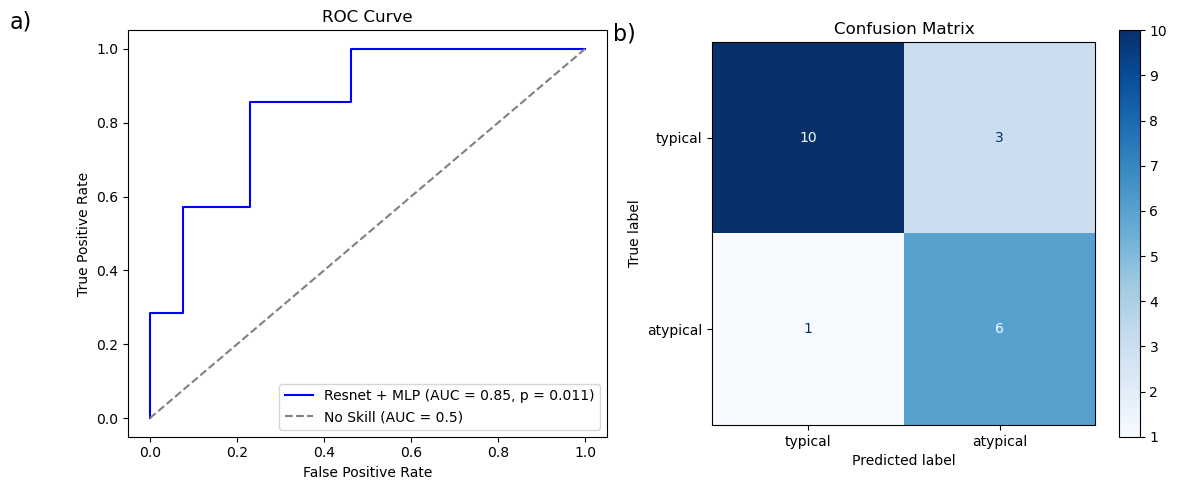

In [6]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
fpr, tpr, thresholds = roc_curve(y_true, pred_probs)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(fpr, tpr, label='Resnet + MLP (AUC = {:.2f}, p = {:.3f})'.format(roc_auc,p_val), color='Blue')
ax[0].plot([0, 1], [0, 1], linestyle='--', label='No Skill (AUC = 0.5)', color='Grey')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()
ax[0].set_title('ROC Curve')
ax[0].text(-0.2, 1.05, 'a)', transform=ax[0].transAxes, fontsize=16, va='top', ha='right')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['typical', 'atypical'])
disp.plot(cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix')
ax[1].text(-0.2, 1.05, 'b)', transform=ax[1].transAxes, fontsize=16, va='top', ha='right')

plt.tight_layout()
plt.savefig("plot3.pdf")
plt.show()